In [3]:
import os 
import pandas as pd
from matplotlib import pyplot as plt

<font size=8>种子点功能连接 Seed-based correlation analysis</font>
# Preparation
* 图像： fsl_anat校正的T1, 静息态，静息态场图
* 预处理： 头动校正、B0 unwarping、slice-timing correction、spatial smoothing、High pass filtering

## Get input images

In [ ]:
#!bin/sh
ses='ses-1/brain'

for sub in ../anat/sub*; do
    sub_id=${sub:8:7}
    mkdir ${sub_id}_rs
    echo $sub_id
    cp $sub/T1_biascorr.nii.gz ${sub_id}_rs/T1_biascorr.nii.gz
    cp $sub/T1_biascorr_brain.nii.gz ${sub_id}_rs/T1_biascorr_brain.nii.gz
    cp $sub/T1_biascorr_brain_mask.nii.gz ${sub_id}_rs/T1_biascorr_brain_mask.nii.gz
    cp ../${sub_id}/${ses}/func/* ${sub_id}_rs/

done

In [ ]:
!sh 1_get_struc.sh

sub-p30 rest fmri image is lost

## Prepare fieldmap

In [ ]:
#!bin/sh
ses='ses-1/brain'
direction='/Home/jzni/SCI/cleaned_data/MRI'

for sub in ../sub*; do
    sub_id=${sub:3}
    cp ${sub}/${ses}/fmap/*rest_bold* ./${sub_id}_rs/
done



for dir in sub-*; do
    sub=${dir:0:7}
    cd $dir
    rm *.json
    if [ -f ${sub}_ses-1_magnitude2_rest_bold.nii.gz ] ; then
    bet ${sub}_ses-1_magnitude2_rest_bold.nii.gz ${sub}_magnitude_brain -f 0.4
    fsl_prepare_fieldmap SIEMENS ${sub}_ses-1_phase2_rest_bold.nii.gz  ${sub}_magnitude_brain ${sub}_fmap_rads 2.46
    else 
    bet ${sub}_ses-1_magnitude_rest_bold.nii.gz ${sub}_magnitude_brain -f 0.4
    fsl_prepare_fieldmap SIEMENS ${sub}_ses-1_phase2_rest_bold.nii.gz  ${sub}_magnitude_brain ${sub}_fmap_rads 2.46
    fi 
    cd ..
done


In [ ]:
!sh 2_prepare_fmap.sh

# Feat

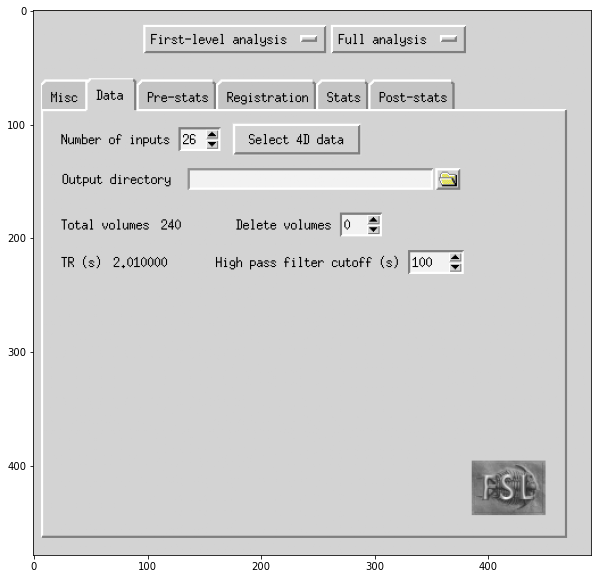

In [6]:
plt.figure(figsize=(10, 12))
im = plt.imread('./etc/feat_design/data.png')
plt.imshow(im)

## Pre-stats

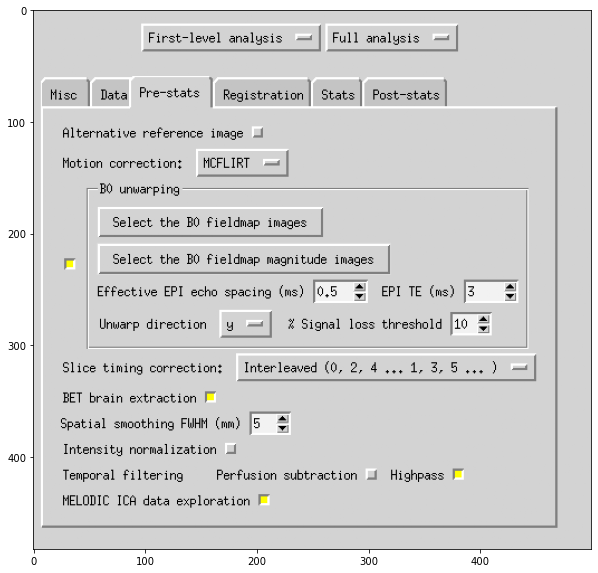

In [7]:
plt.figure(figsize=(10, 12))
im = plt.imread('./etc/feat_design/pre_stat.png')
plt.imshow(im)

## Registration

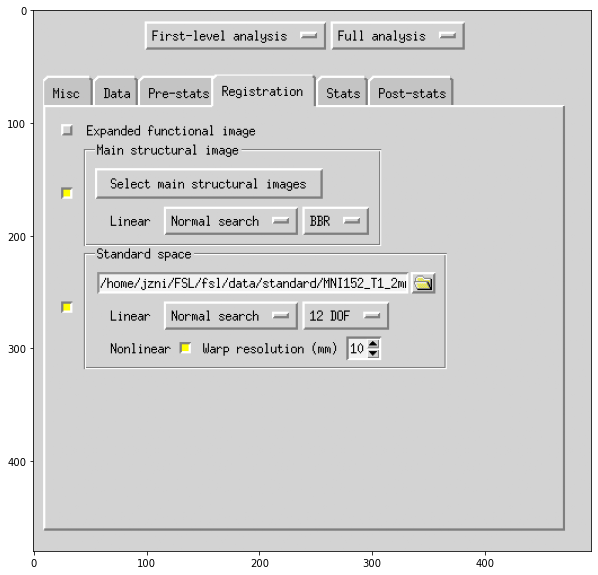

In [5]:
plt.figure(figsize=(10, 12))
im = plt.imread('./etc/feat_design/registration.png')
plt.imshow(im)

## Show Preprocessing Report
c15 头动严重， 剔除; p13 图像采集时的质量很差，无法使用。均已经剔除

In [2]:
!sub=c0; firefox sub-${sub}_rs/sub-${sub}_ses-1_rest_bold.feat/report.html

**17 Control, 9 Patient**   
sub-p30 rest image is lost  
sub-p13 rest image is corrupted    
sub-c15 has lots of head motion

# Seed-based Correlation analysis

## ROIs

In [17]:
def show_png(png,figsize=(10,12)):
    plt.figure(figsize=figsize)
    im = plt.imread(png)
    plt.imshow(im)
    plt.show()

m1.png


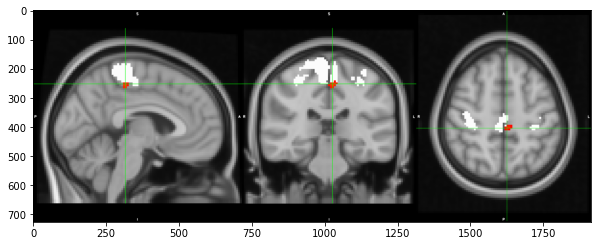

MFG.png


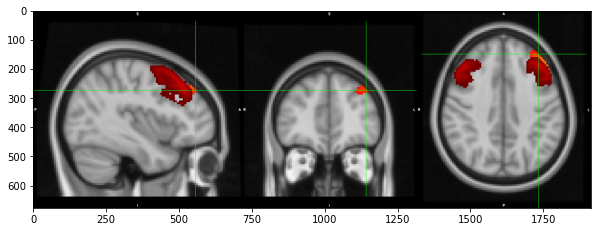

Insula.png


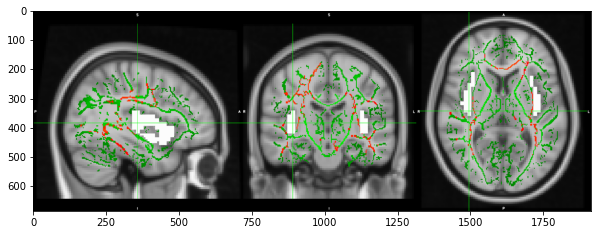

M1.png


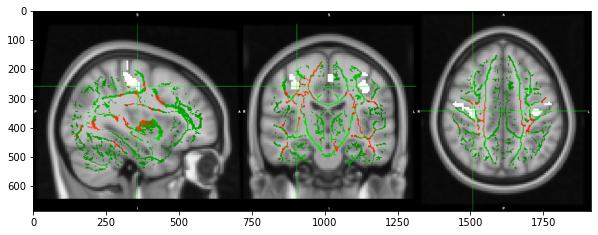

acc.png


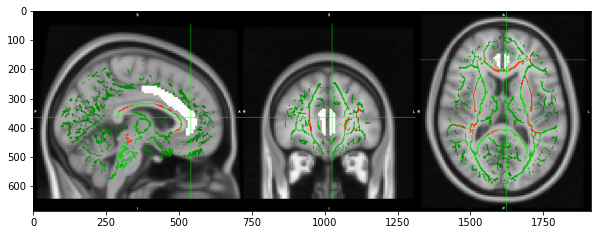

s1.png


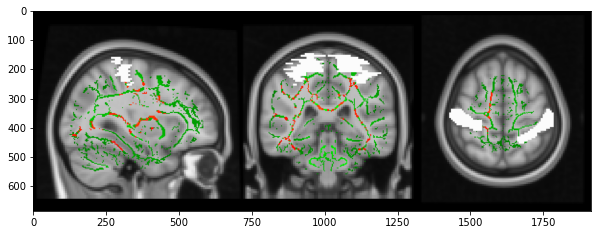

s2.png


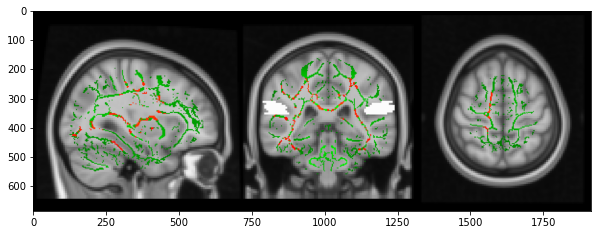

PAG.png


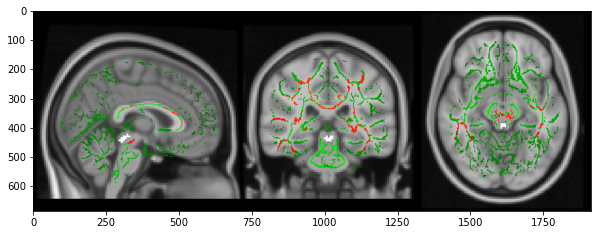

thalamus.png


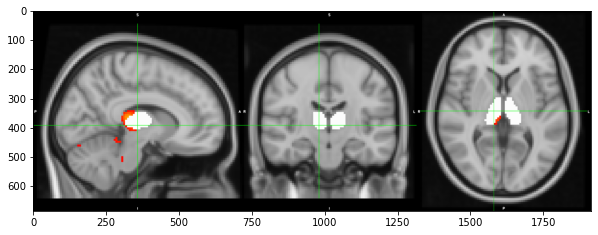

In [20]:
direct = 'seed/choose_seed/'
for img in os.listdir(direct):
    print(img)
    show_png(direct+img)

## Create Masks
### masks from atlas

In [11]:
# threshold
!fslmaths seed/norm_mask/vbm_MFG.nii.gz -thr 30 -bin seed/norm_mask/MFG

### resample masks

In [76]:
# resample and rethreshold
!sub_dir='sub-c01_rs/sub-c01_ses-1_rest_bold.feat' ; mask_list=`ls seed/norm_mask/*` ; \
for f in $mask_list ; do \

applywarp -i $f -r ${sub_dir}/reg/example_func.nii.gz -o seed/rest_mask/${f:15} \
  --postmat=${sub_dir}/reg/standard2example_func.mat -w ${sub_dir}/reg/highres2standard_warp ; \

fslmaths seed/rest_mask/${f:15} -thr 0.1 -bin seed/rest_mask/${f:15} ; \
done

In [64]:
# !fnirt --ref=sub-c01_rs/sub-c01_ses-1_rest_bold.feat/reg/example_func.nii.gz --in=seed/norm_mask/MFG_thr.nii.gz --iout=seed/rest_mask/MFG.nii.gz

## extract meants

In [77]:
!mask=`ls seed/rest_mask/*` ; \
for dir in sub*/*.feat ; do \
    rm -rf ${dir:0:10}/meants ;\
    mkdir ${dir:0:10}/meants ; \
    for m in $mask ; do \
        fslmeants -i ${dir}/filtered_func_data.nii.gz -o ${dir:0:10}/meants/${dir:0:7}_${m:15:-7}.txt -m $m ; \
    done; \
done

## feat stat  using single timecourse
folder_structure:  
sub-c01_rs    
--sub-c01_ses-1_rest_bold.feat    
--meants    
-raw files    

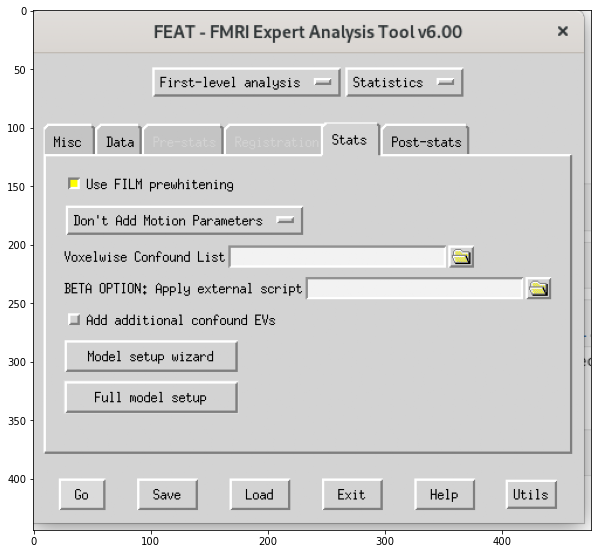

In [8]:
plt.figure(figsize=(10, 12))
im = plt.imread('feat1.png')
plt.imshow(im)

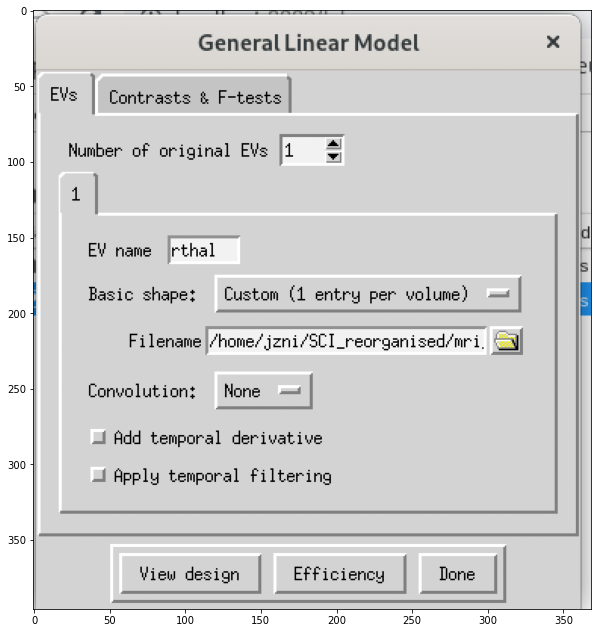

In [9]:
plt.figure(figsize=(10, 12))
im = plt.imread('feat2.png')
plt.imshow(im)

### ev setup in design.fsf

In [ ]:
# EV 1 title
set fmri(evtitle1) "right_thalamus"

# Basic waveform shape (EV 1)
# 0 : Square
# 1 : Sinusoid
# 2 : Custom (1 entry per volume)
# 3 : Custom (3 column format)
# 4 : Interaction
# 10 : Empty (all zeros)
set fmri(shape1) 2

# Convolution (EV 1)
# 0 : None
# 1 : Gaussian
# 2 : Gamma
# 3 : Double-Gamma HRF
# 4 : Gamma basis functions
# 5 : Sine basis functions
# 6 : FIR basis functions
# 8 : Alternate Double-Gamma
set fmri(convolve1) 0

# Convolve phase (EV 1)
set fmri(convolve_phase1) 0

# Apply temporal filtering (EV 1)
set fmri(tempfilt_yn1) 1

# Add temporal derivative (EV 1)
set fmri(deriv_yn1) 1

# Custom EV file (EV 1)
set fmri(custom1) "/home/jzni/SCI_reorganised/mri_analysis/rest/sub-c01_rs/meants/sub-c01_right_Thalamus.txt"

# Orthogonalise EV 1 wrt EV 0
set fmri(ortho1.0) 0

# Orthogonalise EV 1 wrt EV 1
set fmri(ortho1.1) 0

# Orthogonalise EV 1 wrt EV 2
set fmri(ortho1.2) 0

run feat stat for every subject

In [11]:
# https://github.com/andrewjahn/FSL_Scripts/blob/master/run_1stLevel_Analysis.sh
#!/bin/bash

# Generate the subject list to make modifying this script
# to run just a subset of subjects easier.
cd ~/SCI_reorganised/mri_analysis/rest
for dir in sub* ; do
    subj=${dir:0:7}
    echo "===> Starting processing of $subj"
    cd $dir/${subj}_ses-1_rest_bold.feat
        
        # Copy the design files into the subject directory, and then
        # change “sub-01” to the current subject number
        cp ../../design.fsf .
        
        # Note that we are using the | character to delimit the patterns
        # instead of the usual / character because there are / characters
        # in the pattern.
        sed -i "s|sub-c01|${subj}|g" design.fsf

        # Now everything is set up to run feat
        echo "===> Starting feat"
        feat design.fsf

    # Go back to the directory containing all of the subjects, and repeat the loop
    cd ../..
done

echo

===> Starting processing of sub-c01
===> Starting feat
===> Starting processing of sub-c02
===> Starting feat
===> Starting processing of sub-c03
===> Starting feat
===> Starting processing of sub-c04
===> Starting feat
===> Starting processing of sub-c05
===> Starting feat
===> Starting processing of sub-c06
===> Starting feat
===> Starting processing of sub-c07
===> Starting feat
===> Starting processing of sub-c09
===> Starting feat
===> Starting processing of sub-c10
===> Starting feat
===> Starting processing of sub-c11
===> Starting feat
===> Starting processing of sub-c12
===> Starting feat
===> Starting processing of sub-c13
===> Starting feat
===> Starting processing of sub-c14
===> Starting feat
===> Starting processing of sub-c16
===> Starting feat
===> Starting processing of sub-c17
===> Starting feat
===> Starting processing of sub-c18
===> Starting feat
===> Starting processing of sub-c19
===> Starting feat
===> Starting processing of sub-p14
===> Starting feat
===> Start

In [3]:
ls -d /home/jzni/SCI_reorganised/mri_analysis/rest/sub*/*.feat

/home/jzni/SCI_reorganised/mri_analysis/rest/sub-c01_rs/sub-c01_ses-1_rest_bold.feat/
/home/jzni/SCI_reorganised/mri_analysis/rest/sub-c02_rs/sub-c02_ses-1_rest_bold.feat/
/home/jzni/SCI_reorganised/mri_analysis/rest/sub-c03_rs/sub-c03_ses-1_rest_bold.feat/
/home/jzni/SCI_reorganised/mri_analysis/rest/sub-c04_rs/sub-c04_ses-1_rest_bold.feat/
/home/jzni/SCI_reorganised/mri_analysis/rest/sub-c05_rs/sub-c05_ses-1_rest_bold.feat/
/home/jzni/SCI_reorganised/mri_analysis/rest/sub-c06_rs/sub-c06_ses-1_rest_bold.feat/
/home/jzni/SCI_reorganised/mri_analysis/rest/sub-c07_rs/sub-c07_ses-1_rest_bold.feat/
/home/jzni/SCI_reorganised/mri_analysis/rest/sub-c09_rs/sub-c09_ses-1_rest_bold.feat/
/home/jzni/SCI_reorganised/mri_analysis/rest/sub-c10_rs/sub-c10_ses-1_rest_bold.feat/
/home/jzni/SCI_reorganised/mri_analysis/rest/sub-c11_rs/sub-c11_ses-1_rest_bold.feat/
/home/jzni/SCI_reorganised/mri_analysis/rest/sub-c12_rs/sub-c12_ses-1_rest_bold.feat/
/home/jzni/SCI_reorganised/mri_analysis/rest/sub-c13_r

## Group level analysis

In [2]:
!firefox r_thal.gfeat/cope1.feat/report_stats.html


###!!! [Parent][RunMessage] Error: Channel closing: too late to send/recv, messages will be lost

